# Author analysis


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

DATA_FOLDER = "../data/"

%load_ext blackcellmagic

In [2]:
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
articles = pd.read_json(DATA_FOLDER + "filtered.jsonl", lines=True)

In [4]:
articles.head(10)

,date,fulltext,id,pages,title,type
0,1900-10-15,CONFÉDÉRATION S 01 SSE Militaire. — Le départe...,GDL-1900-10-15-a-i0014,[2],CONFÉDÉRATION S01SSE,ar
1,1900-02-03,CONFÉDÉRATION SOISSE Nominations. — Le Conseil...,GDL-1900-02-03-a-i0013,[2],CONFÉDÉRATION SOISSE,ar
2,1900-08-06,CONFÉDÉRATION SUISSE Drainage des écus. — D'ap...,GDL-1900-08-06-a-i0014,[2],CONFÉDÉRATION SUISSE,ar
3,1900-02-15,"Le drainage des éens. Genève, 14 février. Lund...",GDL-1900-02-15-a-i0006,[1],Le drainage des éens.,ar
4,1900-06-11,CONFÉDÉRATION SOISS Sonnerie de cloches. — Le ...,GDL-1900-06-11-a-i0015,[2],CONFÉDÉRATION SOISS,ar
5,1900-05-25,CONFÉDÉRATION SUISSE Expulsions. — Le Conseil ...,GDL-1900-05-25-a-i0010,[2],CONFÉDÉRATION SUISSE,ar
6,1900-05-26,"BULLETIN POLITIQUE Lausanne, 26 mai 1900. lie ...",GDL-1900-05-26-a-i0002,[1],BULLETIN POLITIQUE,ar
7,1900-09-08,KOUVELiES DES CANTONS BERNE. — L'institut vacc...,GDL-1900-09-08-a-i0016,[2],KOUVELiES DES CANTONS,ar
8,1900-11-22,CONFÉDÉRATION SUISSE Budget. — La commission d...,GDL-1900-11-22-a-i0013,[2],CONFÉDÉRATION SUISSE,ar
9,1900-11-24,CONFÉDÉRATION SUISSE Chemins de fer. — Le Cons...,GDL-1900-11-24-a-i0015,[2],CONFÉDÉRATION SUISSE Chemins de fer. — Le Cons...,ar


In [5]:
len(articles)

34582

In [6]:
jdg_indexes = articles.id.str.contains("JDG")
gdl_indexes = articles.id.str.contains("GDL")

print(
    "JDG: ",
    jdg_indexes.sum(),
    "\nGDL: ",
    gdl_indexes.sum()
)

JDG:  13487 
GDL:  21095


In [7]:
banking_indexes =  articles.fulltext.str.lower().str.contains("secret bancaire")
banking_indexes.sum()

1737

## Different types of authors

#### Agencies

- **ATS** Agence télégraphique suisse
- **AFP** Agence France-Presse
- **Reuters** 
- **AP**: Associated press

In [22]:
def agency_indexes(agency_pattern):
    return articles.fulltext.str.lower().str.contains(agency_pattern)

ats_indexes = agency_indexes(r"\(a\.?t\.?s\.?\)")
ap_indexes = agency_indexes(r"\((a\.?p\.?|associated press\.?)\)")
afp_indexes = agency_indexes(r"\(a\.?f\.?p\.?\)")
reuter_indexes = agency_indexes(r"\(reuters?\.?\)")

foreign_agency_indexes = ap_indexes | afp_indexes | reuter_indexes
agency_indexes = ats_indexes | foreign_agency_indexes
agency_indexes.sum()


/Users/yann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


6355

In [9]:
(banking_indexes & agency_indexes).sum() / banking_indexes.sum()

0.2867012089810017

In [10]:
agency_indexes.sum() / articles.shape[0]

0.18376612110346424

In [11]:
def year_series(series):
    year_series = series.date.dt.year
    delta_years = year_series.max() - year_series.min()   
    return year_series, delta_years
    

def year_hist(series):
    years, bins = year_series(series)
    plt.ylabel("nombre d'articles")
    return years.hist(bins=bins)

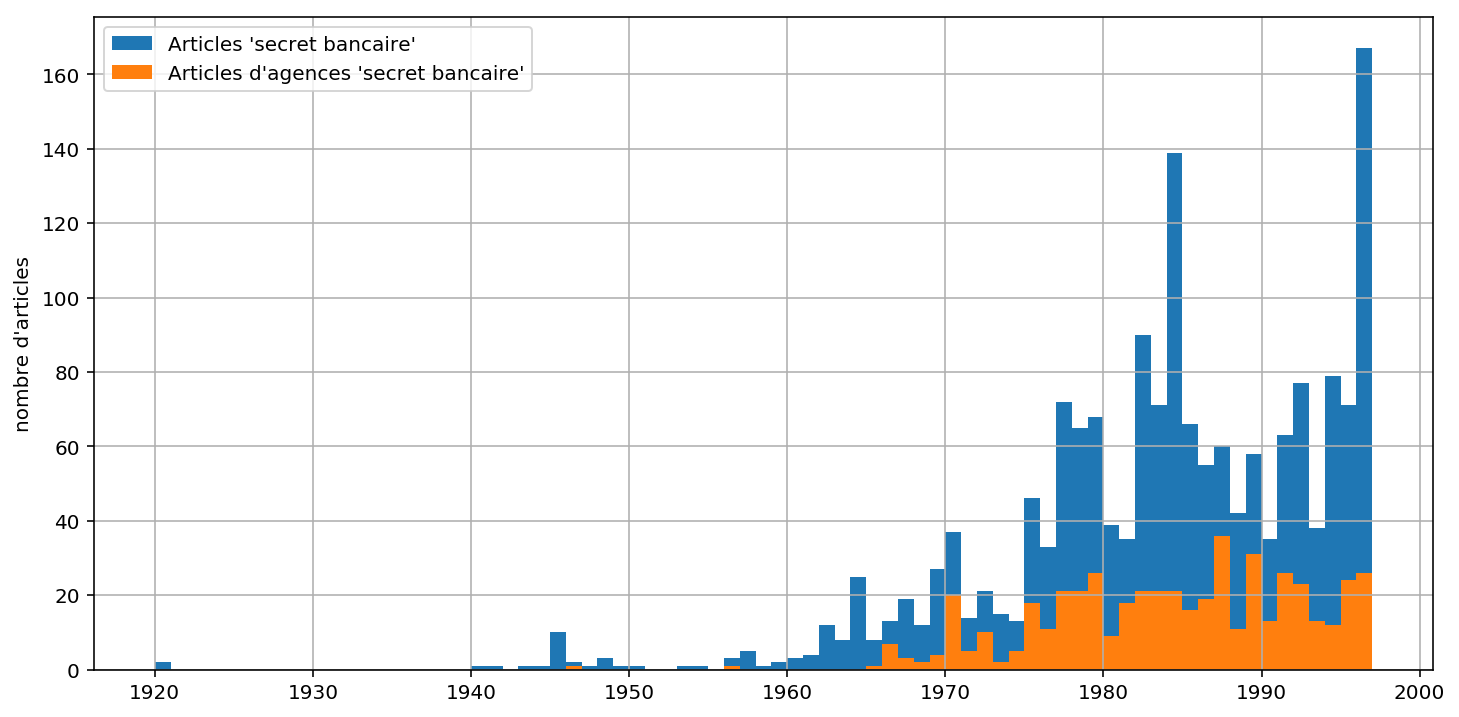

In [12]:
year_hist(articles[banking_indexes])
year_hist(articles[banking_indexes & agency_indexes]);

plt.legend([
    "Articles 'secret bancaire'", 
    "Articles d'agences 'secret bancaire'"
]);
plt.savefig("../rapport/analysis/angency_banking_hist.png", dpi=200);

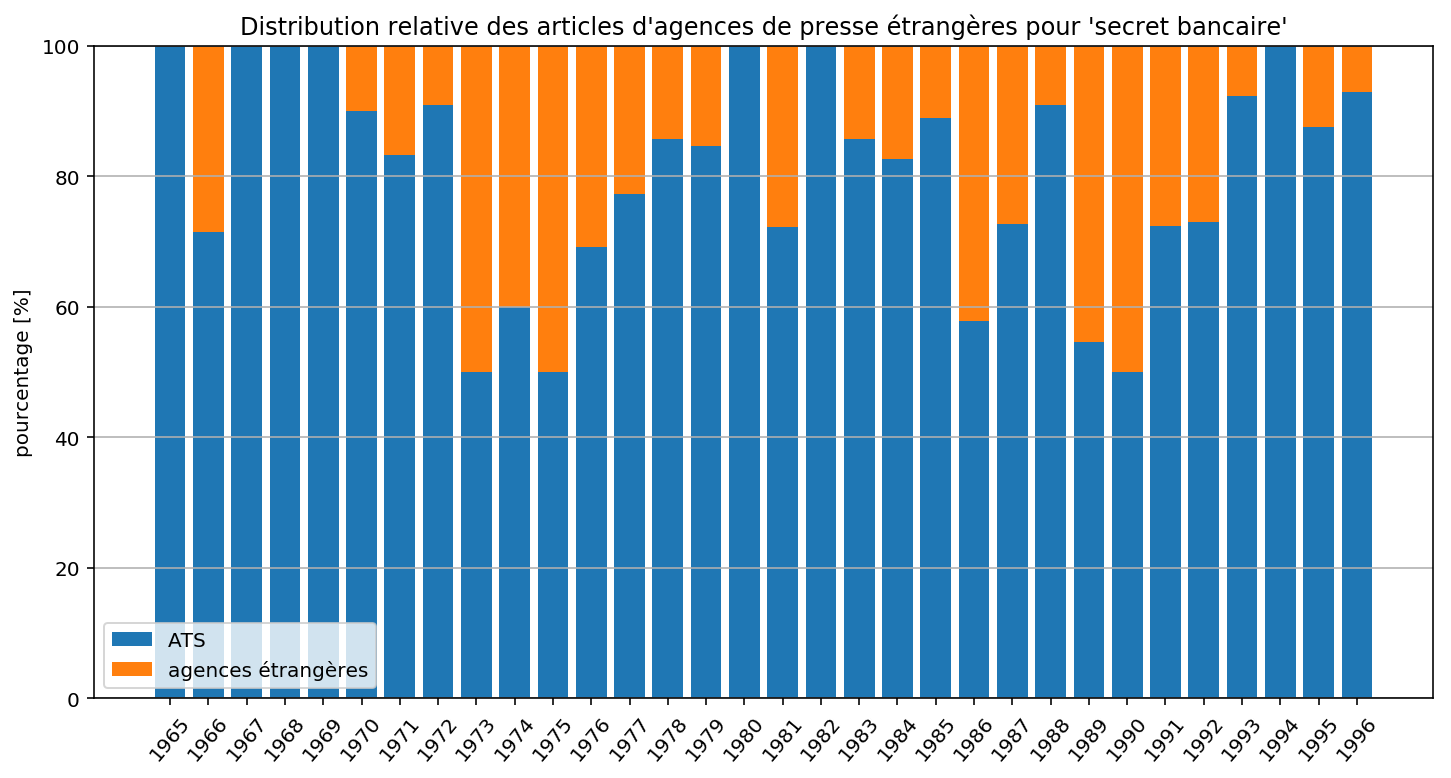

In [41]:
years = range(1965, 1998)

ats_banking_series, _ = year_series(articles[ats_indexes & banking_indexes])
for_banking_series, _ = year_series(articles[foreign_agency_indexes & banking_indexes])

ats_banking_hist, _ = np.histogram(ats_banking_series, bins=years)
for_banking_hist, _ = np.histogram(for_banking_series, bins=years)

total = ats_banking_hist + afp_banking_hist
ats_percentage = 100.0 * ats_banking_hist / total
for_percentage = 100.0 * for_banking_hist / total

plt.bar(
    np.array(years[:-1]),
    ats_percentage,
    label="ATS",
)

plt.bar(
    np.array(years[:-1]),
    for_percentage,
    bottom=ats_percentage,
    label="agences étrangères",
)

plt.title("Distribution relative des articles d'agences de presse étrangères pour 'secret bancaire'")
plt.legend()
plt.ylabel("pourcentage [%]")
plt.grid(axis='y')

plt.xticks(years[:-1], rotation=50)
plt.savefig("../rapport/analysis/afp_ats_percentage.png", dpi=200);

#### Authors

In [11]:
fulltext = articles[articles.id.str.contains("JDG-1987-08-13")].iloc[0].fulltext
fulltext

'MARCHÉ DES CAPITAUX Syndicats d\'émissions : les grandes banques libéralisent ,.\'-il. : L\'. ,.... „, ; ,. : .,, (. 1 \'" Les trois grandes banques suisses ont annonce mercredi qu\'elles s\'apprêtaient à ouvrir sous certaines conditions, leur syndicat d\'émission d\'emprunts sur le marché suisse des capitaux, à des émissions dirigées par des banques étrangères établies en Suisse. Des détails sur cène mesure de libéralisation, qui répond à l\'internationalisation croissante du marché des capitaux, seront gués ultérieurement, ont annoncé les trois grandes banques (UBS, Crédit Suisse et SBS) dans un communiqué. J .-L. L. '

In [12]:
initials_pattern = r"\w{2,}\s*\.\s*((\s*\-?\w\s*\.\s*){2,4})$"
re.search(initials_pattern, fulltext)

<_sre.SRE_Match object; span=(596, 618), match='communiqué. J .-L. L. '>

In [13]:
initials_matches = (
    articles.fulltext.str.extract(initials_pattern)
    .dropna()[0]
    .apply(lambda s: s.upper().replace(" ", ""))
)

In [14]:
initials_indexes = articles.index.isin(initials_matches.index)
len(initials_matches)

913

In [16]:
initials_counts = (
    pd.DataFrame(
        {
            "total": initials_matches.value_counts(),
            "JDG": initials_matches[jdg_indexes].value_counts(),
            "GDL": initials_matches[gdl_indexes].value_counts(),
        }
    )
    .sort_values("total", ascending=False)
    .fillna(0)
    .astype(int)
)


initials_counts.head(10)

,total,JDG,GDL
J.-L.L.,154,75,79
F.L.,135,1,134
J.R.,34,16,18
G.R.,30,0,30
S.A.,28,21,7
H.V.,24,24,0
A.K.,23,23,0
J.-S.E.,19,12,7
A.V.,19,12,7
M.-J.K.,18,9,9


In [17]:
initials_counts.sort_values("GDL", ascending=False).head()

,total,JDG,GDL
F.L.,135,1,134
J.-L.L.,154,75,79
G.R.,30,0,30
J.R.,34,16,18
F.W.,11,0,11


In [18]:
initials_counts.sort_values("JDG", ascending=False).head()

,total,JDG,GDL
J.-L.L.,154,75,79
H.V.,24,24,0
A.K.,23,23,0
S.A.,28,21,7
J.R.,34,16,18


In [273]:
frequent_initials = initials_counts.head(12).index

In [274]:
(initials_indexes & agency_indexes).sum()

21

In [275]:
with open(DATA_FOLDER + "authors_jdg.txt", "r") as f:
    authors_jdg_list = f.read()

# a map from initials to the set of authors with thos initials
authors_jdg = {}
for author in authors_jdg_list.split("\n"):
    initials = ""
    for name_part in author.split(" "):
        if "-" in name_part:
            single_name = name_part.split("-")
            initials += single_name[0][:1] + ".-" + single_name[1][:1] + "."
        else:
            initials += name_part[:1] + "."

    if len(initials) > 1:
        if initials in authors_jdg:
            authors_jdg[initials].add(author)
        else:
            authors_jdg[initials] = set([author])


for initials in frequent_initials:
    if initials in authors_jdg:
        print(authors_jdg[initials])
    else:
        print(initials)

{'Jean-Luc Lederrey'}
F.L.
{'Jean Roussel'}
G.R.
{'Sylvie Arsever'}
{'Henri Villy'}
{'André Klopmann'}
{'Jacques-Simon Eggly'}
{'André Vallana', 'Anton Vos'}
M.-J.K.
{'Pierre Novello'}
V.S.


#### Author's full name

In [22]:
from functools import reduce

authors_jdg_set = reduce(lambda s1, s2: s1 | s2, authors_jdg.values())
jdg_pattern = "(" + "|".join(authors_jdg_set) + ")"

full_name = (
    articles.fulltext.str.extract(jdg_pattern, flags=re.IGNORECASE)[0]
    .dropna()
    .str.lower()
    .str.strip()
)

1772
2670


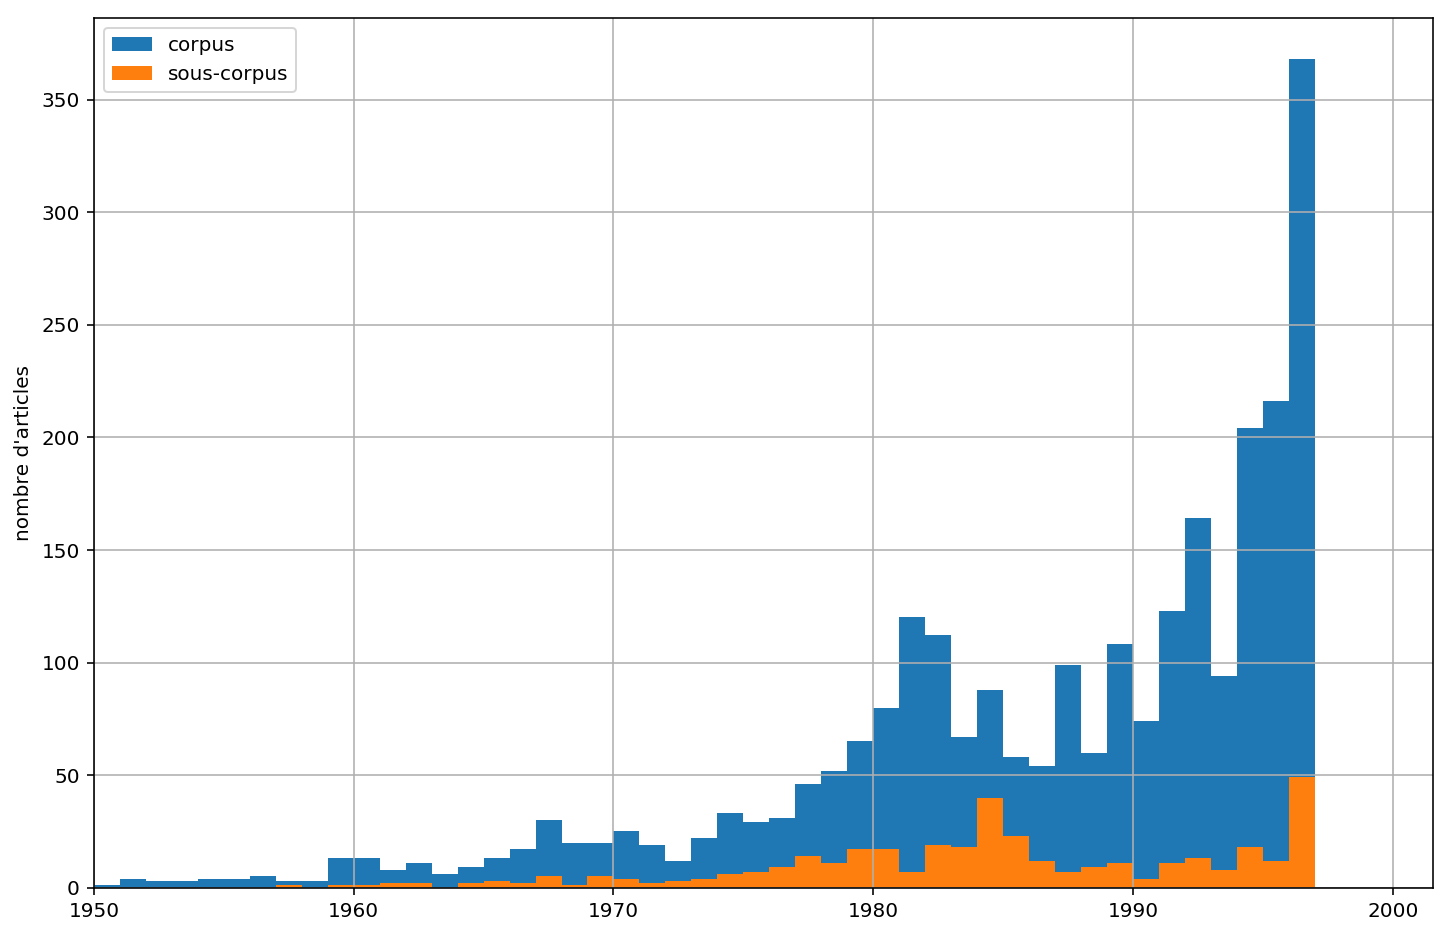

In [222]:
full_name_indexes = articles.index.isin(full_name.index)
print(full_name_indexes.sum())

attributed_indexes = full_name_indexes | initials_indexes
print(attributed_indexes.sum())

year_hist(articles[attributed_indexes]);
year_hist(articles[attributed_indexes & banking_indexes]);

plt.axis(xmin=1950);
plt.ylabel("nombre d'articles")
plt.legend(["corpus", "sous-corpus"]);

plt.savefig("../rapport/methodology/author_attributed.png", dpi=200)

NameError: name 'attributed_indexes' is not defined

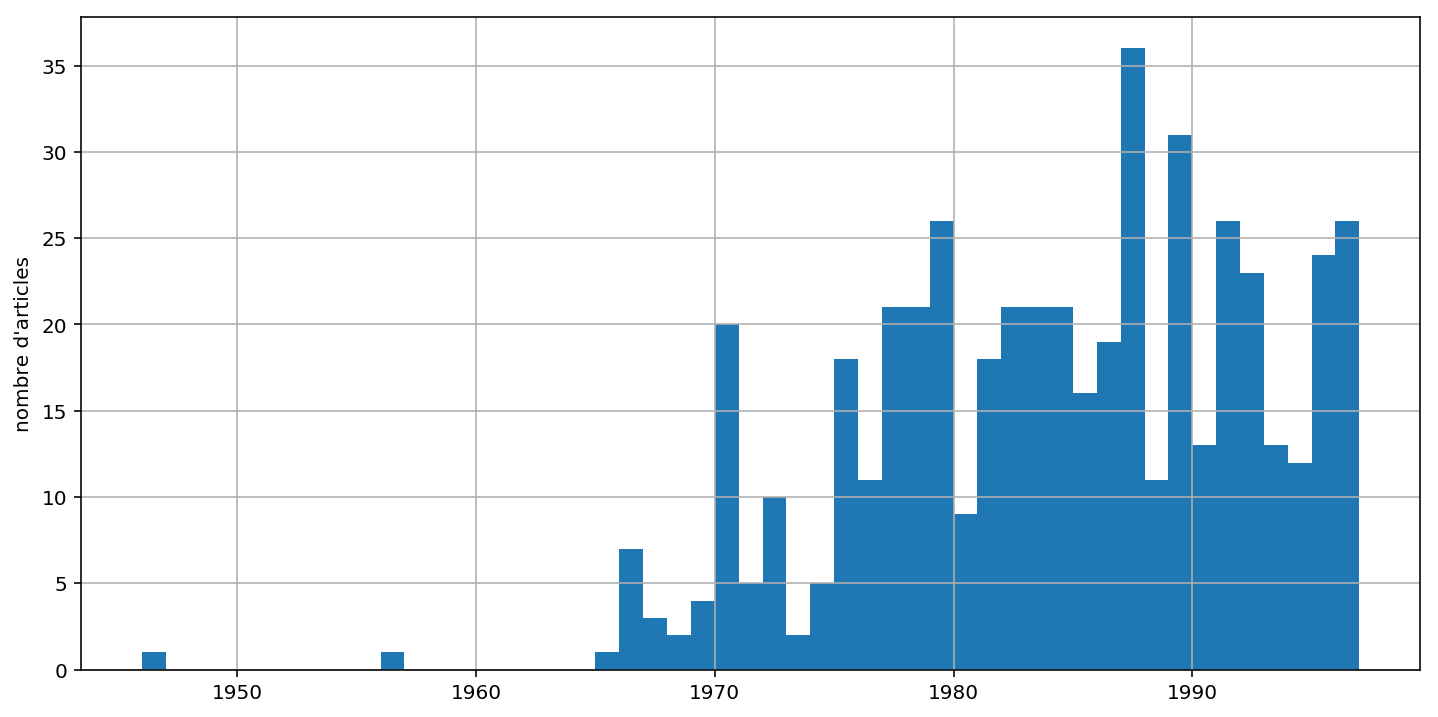

In [28]:
year_hist(articles[agency_indexes & banking_indexes]);
year_hist(articles[attributed_indexes & banking_indexes]);
year_hist(articles[foreign_agency_indexes & banking_indexes]);

plt.legend([
    "agences de presse", 
    "auteurs propres", 
    "agences étrangères"
]);
plt.savefig("../rapport/analysis/authors_agency_count.png", dpi=200);

In [276]:
full_name[banking_indexes & (articles.date.dt.year <= 1990)].value_counts()

jean-luc lederrey      55
jacques-simon eggly    52
françoise blaser       11
sylvie arsever         10
françoise buffat        8
pierre novello          7
jasmine audemars        4
isabelle martin         4
michel petitpierre      3
olivier reverdin        3
nuno sepulveda          2
marian stepczynski      2
paul ladame             2
martine lamunière       1
henri villy             1
claude monnier          1
jean-claude poulin      1
pascal garcin           1
Name: 0, dtype: int64

In [277]:
initials_matches[banking_indexes & (articles.date.dt.year <= 1990)].value_counts()

J.-L.L.    31
J.R.       10
D.-S.M.     7
S.A.        6
J.-S.E.     5
A.-M.L.     5
H.V.        4
H.S.        3
G.P.        3
M.-J.K.     2
X.P.        2
F.W.        2
M.S.        2
V.S.        2
D.A.        2
J.-C.R.     2
C.M.        1
F.B.        1
C.-E.L.     1
M.K.        1
-E.R.       1
J.A.        1
F.L.        1
P.-A.S.     1
R.R.        1
R.L.        1
J.-P.G.     1
A.W.        1
J.S.E.      1
G.D.        1
M.P.        1
-H.P.       1
J.1.L.      1
J.S.        1
R.D.        1
Name: 0, dtype: int64

#### Rédaction

In [211]:
red_indexes = articles.fulltext.str.contains("\([R|r][é|e]d\.?\)")
red_indexes.sum()

261

In [212]:
(red_indexes & (ats_indexes | afp_indexes | initials_indexes)).sum()

105

--> too much overlap! Don't use.

In [55]:
articles[
    foreign_agency_indexes
    & banking_indexes
    & (articles.date.dt.year >= 1986)
    & (articles.date.dt.year <= 1992)
].sort_values("date")

,date,fulltext,id,pages,title,type
16205,1986-01-23,"La Bank of America mise à l'amende Washington,...",GDL-1986-01-23-a-i0131,[15],La Bank of America mise à l'amende,ar
28613,1986-01-23,"La Bank of Amerlca I I'. ""'. mise à l'amende W...",JDG-1986-01-23-a-i0004,[9],"La Bank of Amerlca I I '.""'.• mise à l'amende",ar
16243,1986-03-20,Le secret bancaire sur la fortune de Marcos po...,GDL-1986-03-20-a-i0109,[11],Le secret bancaire sur la fortune de Marcos po...,ar
28423,1986-03-20,LÉGISLATION Le secret bancaire sur la fortune ...,JDG-1986-03-20-a-i0006,[14],LÉGISLATION Le secret bancaire sur la fortune ...,ar
28475,1986-03-21,"BANQUES ""' 1 -..'.. Le Crédit Suisse renforce ...",JDG-1986-03-21-a-i0001,[17],"BANQUES ""'1 -. .'.. Le Crédit Suisse renforce ...",ar
28476,1986-03-21,"~ PHILIPPINES /. , [e-, « NewYorkTiïnès' » pub...",JDG-1986-03-21-a-i0004,[8],"~PHILIPPINES/. ,[e-,«NewYorkTiïnès'» publie la...",ar
16410,1986-03-21,PHILIPPINES Le « New York Times » publie la li...,GDL-1986-03-21-a-i0259,[29],PHILIPPINES Le « New York Times » publie la li...,ar
16388,1986-10-14,ÉLECTRONIQUE Valtronic : une entreprise vaudoi...,GDL-1986-10-14-a-i0120,[15],ÉLECTRONIQUE Valtronic: une entreprise vaudois...,ar
16901,1987-01-15,SOCIETES Affaire Guinness : la Banque Leu veut...,GDL-1987-01-15-a-i0118,[15],SOCIETES,ar
29096,1987-01-15,SOCIETES Affaire Guinness : la Banque Leu veut...,JDG-1987-01-15-a-i0005,[9],SOCIETES,ar
